# Imports and traces

In [29]:
from dotenv import load_dotenv
import os

load_dotenv()

True

## Setup llm and vector_store

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

llm = ChatOpenAI(model="o4-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

PMBOK_vector_store = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)

In [3]:
PMBOK_retriever = PMBOK_vector_store.as_retriever(search_type="mmr")

## Retriever tool

In [4]:
def PMBOK_retriever_tool(query: str) -> str:
    """
    Uses semantic search to retrieve the parts of Project Management Body of Knowledge (PMBOK) documentation
    that could be most relevant to answer your query.
    """
    docs = PMBOK_retriever.invoke(query)
    # Format the retrieved documents for readability
    return "\nRetrieved documents:\n" + "".join(
        [
            f"\n\n===== Document {str(i)} =====\n" + doc.page_content
            for i, doc in enumerate(docs)
        ]
    )

## Search tool

In [5]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=3)

### Sanity checks

In [6]:
llm_with_tools = llm.bind_tools([PMBOK_retriever_tool, tavily_tool])

In [32]:
res = llm_with_tools.invoke("hi")

In [33]:
res

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 818, 'total_tokens': 845, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--c6a42cdd-d896-4f9e-bb34-149ff8b80d99-0', usage_metadata={'input_tokens': 818, 'output_tokens': 27, 'total_tokens': 845, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [31]:
res.additional_kwargs

{'tool_calls': [{'id': 'call_Fg4CXB3NJcEWeTayrbzZ3ulw',
   'function': {'arguments': '{"query":"what does project mean in PMBOK"}',
    'name': 'PMBOK_retriever_tool'},
   'type': 'function'}],
 'refusal': None}

# Graphs

## Nodes and states

In [9]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    Represents the state of the memory graph.
    """
    messages: Annotated[list, add_messages]
    plan: Annotated[list, add_messages]
    retrieved_docs: Annotated[list, add_messages]
    search_results: Annotated[list, add_messages]
    summary: str
    final_answer: str
    session_summary: str

In [10]:
from langchain_core.messages import HumanMessage, AIMessage

def analyze_query(state: State) -> State:
    """
    Analyzes the query using the PMBOK retriever and Tavily search tool.
    Can be called multiple times to refine the analysis based on gathered information.
    Returns a state object with updated analysis and plan.
    """
    # Check if this is a re-analysis (we already have some information)
    is_reanalysis = bool(state.get("retrieved_docs") or state.get("search_results"))
    
    if is_reanalysis:
        ANALYZER_SYSTEM_PROMPT = """
You are an expert Project Management AI Assistant conducting a follow-up analysis. You've already gathered some information and now need to refine your approach based on what you've learned.

## Current Situation:
- Original Query: {original_query}
- Previous Plan: {previous_plan}
- Information Gathered So Far: {gathered_info}

## Your Task:
Based on the information you now have, determine if:
1. You have sufficient information to provide a comprehensive answer
2. You need to gather additional PMBOK information with different search terms
3. You need to search for more current/practical information online
4. You need to refine your approach entirely

## Updated Analysis:
Provide an updated execution plan that either:
- Concludes that you have enough information and should proceed to synthesis
- Identifies specific gaps and what additional information is needed
- Suggests new search terms or approaches based on initial findings

Be specific about what you learned and what's still missing.
"""
        
        # Get context for re-analysis
        original_query = state["messages"][-1].content if state["messages"] else ""
        previous_plan = state["plan"][-1].content if state["plan"] else ""
        
        # Summarize gathered information
        gathered_info = ""
        if state.get("retrieved_docs"):
            gathered_info += f"PMBOK Info: {len(state['retrieved_docs'])} document(s) retrieved. "
        if state.get("search_results"):
            gathered_info += f"Web Search: {len(state['search_results'])} search result(s) found. "
        if state.get("session_summary"):
            ANALYZER_SYSTEM_PROMPT += f"\n\nHere is the summary for this chat session: {state['session_summary']}"
        if state.get("messages"):
            ANALYZER_SYSTEM_PROMPT += "\n\nPrevious messages:\n" + "\n".join(
                [f"{"Human Message" if i % 2 == 0 else "AI Message"}: {msg.content}" for i, msg in enumerate(state["messages"])]
            )
            
        prompt_input = ANALYZER_SYSTEM_PROMPT.format(
            original_query=original_query,
            previous_plan=previous_plan,
            gathered_info=gathered_info if gathered_info else "No information gathered yet."
        )
        
    else:
        # Original analysis prompt
        ANALYZER_SYSTEM_PROMPT = """
You are an expert Project Management AI Assistant with deep knowledge of the Project Management Body of Knowledge (PMBOK) guide. 
Your primary role is to analyze user queries and create effective execution plans for project management-related questions and tasks.

## Your Core Responsibilities:
1. **Query Analysis**: Carefully analyze the user's query to understand their project management needs, context, and intent.
2. **Strategic Planning**: Create a clear, step-by-step plan to address the query effectively.
3. **Tool Selection**: Determine which tools are necessary to provide comprehensive and accurate responses.
4. **PMBOK Adherence**: Always prioritize PMBOK guidelines and best practices in your analysis and recommendations.

## Available Tools:
1. **PMBOK_retriever**: Use this to search and retrieve relevant sections from the Project Management Body of Knowledge guide. This should be your primary reference for:
   - Project management processes and methodologies
   - Best practices and standards
   - Definitions and terminology
   - Framework guidance
   - Knowledge area information

2. **tavily_tool**: Use this for web search when you need:
   - Current industry trends and news
   - Real-world case studies and examples
   - Tools and software recommendations
   - Recent developments in project management
   - Information not covered in PMBOK

## Analysis Framework:
When analyzing a query, follow this systematic approach:

1. **Query Classification**: Determine if the query is:
   - Conceptual (definitions, processes, methodologies)
   - Practical (how-to, implementation guidance)
   - Situational (specific scenarios, problem-solving)
   - Comparative (tool comparisons, methodology differences)

2. **Information Requirements**: Assess what information is needed:
   - Is PMBOK guidance essential? (if yes, plan to use PMBOK_retriever)
   - Do we need current/real-world examples? (if yes, consider tavily_tool)
   - Can the query be answered with existing knowledge? (if yes, no tools needed)

3. **Execution Plan**: Create a clear plan that includes:
   - Which tools to use and in what order
   - Specific search terms or queries for each tool
   - How to synthesize information from multiple sources
   - Expected outcome and deliverable format

## Decision Logic for Tool Usage:
- **Use PMBOK_retriever when**: Query involves PM processes, methodologies, best practices, definitions, or framework guidance
- **Use tavily_tool when**: Query requires current information, real-world examples, industry trends, or specific tools/software
- **Use both tools when**: Query needs both authoritative PMBOK guidance AND current industry context
- **Use no tools when**: Query can be answered with general PM knowledge or requires only clarification

## Plan Structure:
Your plan should be formatted as a numbered list with clear action items:
1. [Action item with rationale]
2. [Tool usage with specific search terms]
3. [Information synthesis approach]
4. [Final deliverable format]

## Important Guidelines:
- Always prioritize PMBOK guidelines as the authoritative source for project management practices
- Be specific about what information you're seeking when using tools
- Consider the user's context and experience level
- Plan for comprehensive yet concise responses
- Anticipate follow-up questions and prepare accordingly

Now, analyze the user's query and create an effective execution plan.
"""
        
        original_query = state["messages"][-1].content if state["messages"] else ""
        prompt_input = f"Query: {original_query}"
    
    # Add history of messages to the prompt
    if state.get("session_summary"):
        ANALYZER_SYSTEM_PROMPT += f"\n\nHere is the summary for this chat session: {state['session_summary']}"
    if state.get("messages"):
        ANALYZER_SYSTEM_PROMPT += "\n\nPrevious messages:\n" + "\n".join(
            [f"{"Human Message" if i % 2 == 0 else "AI Message"}: {msg.content}" for i, msg in enumerate(state["messages"])]
        )


    # Use the LLM to analyze the query and create/update the plan
    analysis_response = llm.invoke([
        {"role": "system", "content": ANALYZER_SYSTEM_PROMPT if not is_reanalysis else prompt_input},
        {"role": "user", "content": prompt_input if not is_reanalysis else "Please provide your updated analysis."}
    ])
    
    # Update the state with new plan while preserving existing information
    updated_state = state.copy() if state else {}
    
    # Initialize if needed
    if not updated_state.get("messages"):
        from langchain_core.messages import HumanMessage
        updated_state["messages"] = [HumanMessage(content=original_query if 'original_query' in locals() else "")]
    
    # Add the new plan
    if not updated_state.get("plan"):
        updated_state["plan"] = []
    from langchain_core.messages import AIMessage
    updated_state["plan"].append(AIMessage(content=analysis_response.content))
    
    # Ensure other fields exist
    if not updated_state.get("retrieved_docs"):
        updated_state["retrieved_docs"] = []
    if not updated_state.get("search_results"):
        updated_state["search_results"] = []
    if not updated_state.get("summary"):
        updated_state["summary"] = ""
    if not updated_state.get("final_answer"):
        updated_state["final_answer"] = ""
    
    return updated_state

In [11]:
def retrieve_pmbok_docs(state: State) -> State:
    """
    Retrieves relevant PMBOK documents based on the current plan and query.
    """
    # Get the latest user query
    latest_message = state["messages"][-1].content if state["messages"] else ""
    
    # Use PMBOK retriever to get relevant documents
    retrieved_docs = PMBOK_retriever_tool(latest_message)
    
    # Update state with retrieved documents
    updated_state = state.copy()
    from langchain_core.messages import SystemMessage
    updated_state["retrieved_docs"] = [SystemMessage(content=retrieved_docs)]
    
    return updated_state

In [12]:
def search_web(state: State) -> State:
    """
    Searches the web using Tavily tool based on the current plan and query.
    """
    # Get the latest user query
    latest_message = state["messages"][-1].content if state["messages"] else ""
    
    # Use Tavily search tool
    search_results = tavily_tool.invoke({"query": latest_message})
    
    # Format search results - handle both string and dict results
    formatted_results = "Web search results:\n"
    if isinstance(search_results, list):
        for i, result in enumerate(search_results):
            if isinstance(result, dict):
                formatted_results += f"\n{i+1}. {result.get('title', 'No title')}\n"
                formatted_results += f"   URL: {result.get('url', 'No URL')}\n"
                formatted_results += f"   Content: {result.get('content', 'No content')[:500]}...\n"
            else:
                formatted_results += f"\n{i+1}. {str(result)[:500]}...\n"
    else:
        formatted_results += f"\n1. {str(search_results)[:500]}...\n"
    
    # Update state with search results
    updated_state = state.copy()
    from langchain_core.messages import SystemMessage
    updated_state["search_results"] = [SystemMessage(content=formatted_results)]
    
    return updated_state

In [13]:
def synthesize_information(state: State) -> State:
    """
    Synthesizes information from PMBOK retrieval and web search to create a summary.
    """
    SYNTHESIS_PROMPT = """
You are synthesizing information to provide a comprehensive project management response.

Based on the following information:
- User Query: {query}
- Execution Plan: {plan}
- PMBOK Retrieved Documents: {pmbok_docs}
- Web Search Results: {search_results}

Create a comprehensive summary that:
1. Addresses the user's query directly
2. Incorporates PMBOK best practices and guidelines
3. Includes relevant current information from web search (if applicable)
4. Provides actionable insights and recommendations

Focus on accuracy, clarity, and practical applicability.
"""
    
    # Extract information from state
    query = state["messages"][-1].content if state["messages"] else ""
    plan = state["plan"][-1].content if state["plan"] else ""
    pmbok_docs = state["retrieved_docs"][-1].content if state["retrieved_docs"] else ""
    search_results = state["search_results"][-1].content if state["search_results"] else ""
    
    # Create synthesis prompt
    synthesis_input = SYNTHESIS_PROMPT.format(
        query=query,
        plan=plan,
        pmbok_docs=pmbok_docs,
        search_results=search_results
    )
    
    # Generate summary using LLM
    synthesis_response = llm.invoke([{"role": "system", "content": synthesis_input}])
    
    # Update state with summary
    updated_state = state.copy()
    updated_state["summary"] = synthesis_response.content
    
    return updated_state

In [14]:
from langchain_core.messages import RemoveMessage, HumanMessage, AIMessage

def generate_final_answer(state: State) -> State:
    """
    Generates the final answer based on the synthesized information.
    """
    FINAL_ANSWER_PROMPT = """
You are an experienced and approachable Project Management Assistant who genuinely cares about helping professionals succeed in their projects. You have years of experience guiding teams through complex initiatives and understand the real-world challenges that project managers face daily.

Your communication style is:
- Warm and personable, like a trusted colleague
- Confident yet humble, acknowledging when situations are complex
- Practical and solution-oriented
- Encouraging and supportive

Context: You've just completed a thorough analysis of the user's project management question, drawing from both the authoritative PMBOK guidelines and current industry insights. You understand that behind every project management question is a real person trying to deliver value, manage stakeholders, meet deadlines, and navigate organizational challenges.

Based on your comprehensive analysis: {summary}

Please provide your response following these guidelines:

**Structure your answer to be:**
1. **Personally engaging** - Start with a brief acknowledgment that shows you understand their situation
2. **Clear and actionable** - Provide concrete steps they can take immediately
3. **Contextually relevant** - Reference specific PMBOK processes or industry practices where appropriate
4. **Professionally formatted** - Use headings, bullet points, and clear sections for easy reading
5. **Encouraging** - Acknowledge challenges while providing confidence in the solution

**Always conclude with:**
- A brief summary of the key takeaway
- 2-3 specific follow-up questions or next steps they might consider, such as:
  * "Would you like me to help you create a template for [specific deliverable]?"
  * "Are there any specific stakeholder challenges you're facing with this approach?"
  * "How does your organization typically handle [relevant process area]?"
  * "Would it be helpful to explore how this applies to your current project phase?"

Remember: You're not just providing information—you're empowering someone to be more effective in their role and deliver better project outcomes.
"""
    
    summary = state["summary"]
    if state.get("session_summary"):
        FINAL_ANSWER_PROMPT += f"\n\nHere is the summary for this chat session: {state['session_summary']}"
    if state.get("messages"):
        FINAL_ANSWER_PROMPT += "\n\nPrevious messages:\n" + "\n".join(
            [f"{"Human Message" if i % 2 == 0 else "AI Message"}: {msg.content}" for i, msg in enumerate(state["messages"])]
        )
    
    # Generate final answer
    final_answer_input = FINAL_ANSWER_PROMPT.format(summary=summary)
    final_response = llm.invoke([{"role": "system", "content": final_answer_input}])
    
    # Update state with final answer
    updated_state = state.copy()
    updated_state["final_answer"] = final_response.content

    # Delete plan, retrieved_docs, search_results
    delete_plan = [RemoveMessage(id=m.id) for m in state["plan"]]
    delete_retrieved_docs = [RemoveMessage(id=m.id) for m in state["retrieved_docs"]]
    delete_search_results = [RemoveMessage(id=m.id) for m in state["search_results"]]
    
    return {
        "plan": delete_plan,
        "retrieved_docs": delete_retrieved_docs,
        "search_results": delete_search_results,
        "final_answer": final_response.content,
        "message": final_response.content
    }

In [15]:
def should_retrieve_pmbok(state: State) -> str:
    """
    Conditional edge function to determine if PMBOK retrieval is needed.
    """
    plan = state["plan"][-1].content if state["plan"] else ""
    
    # Simple logic - check if plan mentions PMBOK retrieval
    if "PMBOK_retriever" in plan or "pmbok" in plan.lower() or "retrieve" in plan.lower():
        return "retrieve_pmbok"
    return "skip_pmbok"

In [16]:
def should_search_web(state: State) -> str:
    """
    Conditional edge function to determine if web search is needed.
    """
    plan = state["plan"][-1].content if state["plan"] else ""
    
    # Simple logic - check if plan mentions web search
    if "tavily" in plan.lower() or "search" in plan.lower() or "web" in plan.lower():
        return "search_web"
    return "skip_search"

In [17]:
def needs_tools(state: State) -> str:
    """
    Ask the agent to explicitly decide if tools are needed instead of keyword matching.
    """
    plan = state["plan"][-1].content if state["plan"] else ""
    
    # Use LLM to make explicit decision
    DECISION_PROMPT = """
Based on the following execution plan, determine if tools are needed to gather information or if you can provide a direct answer.

Execution Plan: {plan}

Respond with EXACTLY ONE of these options:
- "use_tools" if you need to gather information using PMBOK retriever or web search
- "direct_answer" if you can answer directly without additional information gathering

Your response:"""
    
    decision_input = DECISION_PROMPT.format(plan=plan)
    decision_response = llm.invoke([{"role": "user", "content": decision_input}])
    
    decision = decision_response.content.strip().lower()
    if "use_tools" in decision:
        return "use_tools"
    else:
        return "direct_answer"

def analyze_query_node(state: State) -> State:
    """
    Node wrapper for analyze_query that handles both initial and re-analysis cases.
    """
    return analyze_query(state)

def initial_query_analysis(query: str) -> State:
    """
    Initial entry point for analyzing a new query.
    """
    from langchain_core.messages import HumanMessage
    initial_state = State(
        messages=[HumanMessage(content=query)],
        plan=[],
        retrieved_docs=[],
        search_results=[],
        summary="",
        session_summary="",
        final_answer=""
    )
    return analyze_query(initial_state)

def should_continue_analysis(state: State) -> str:
    """
    Ask the agent to explicitly decide the next step after retrieval/search operations.
    """
    plan = state["plan"][-1].content if state["plan"] else ""
    has_pmbok_docs = bool(state.get("retrieved_docs"))
    has_search_results = bool(state.get("search_results"))
    analysis_count = len(state.get("plan", []))
    
    # Prevent infinite loops
    if analysis_count >= 4:
        return "synthesize"
    
    # Prepare context for the agent
    context_info = f"""
Current Analysis Count: {analysis_count}/4
Has PMBOK Documents: {has_pmbok_docs}
Has Web Search Results: {has_search_results}
Latest Plan: {plan}
"""
    
    if has_pmbok_docs:
        context_info += f"\nPMBOK Documents: {len(state['retrieved_docs'])} document(s) retrieved"
    if has_search_results:
        context_info += f"\nWeb Search: {len(state['search_results'])} result(s) found"
    
    DECISION_PROMPT = """
You are determining the next step in information gathering for a project management query. 

Context:
{context}

Based on your current plan and the information you've gathered, decide what to do next.

Respond with EXACTLY ONE of these options:
- "continue_analysis" if you need to refine your approach and re-analyze the query
- "search_web" if you need current industry information, trends, or real-world examples
- "retrieve_more" if you need additional PMBOK documentation or standards
- "synthesize" if you have sufficient information to create a comprehensive answer

Consider:
- Do you have enough authoritative PMBOK information for the query?
- Do you need current market trends or real-world examples?
- Is your current approach working or do you need to refine it?
- Have you gathered sufficient information to provide a complete answer?

Your response:"""
    
    decision_input = DECISION_PROMPT.format(context=context_info)
    decision_response = llm.invoke([{"role": "user", "content": decision_input}])
    
    decision = decision_response.content.strip().lower()
    
    # Map decision to valid edge options
    if "continue_analysis" in decision:
        return "continue_analysis"
    elif "search_web" in decision:
        return "search_web"
    elif "retrieve_more" in decision:
        return "retrieve_more"
    else:
        return "synthesize"

def determine_retrieval_type(state: State) -> str:
    """
    Ask the agent to explicitly decide between PMBOK retrieval and web search.
    """
    plan = state["plan"][-1].content if state["plan"] else ""
    query = state["messages"][-1].content if state["messages"] else ""
    
    DECISION_PROMPT = """
You need to gather information for a project management query. Decide which tool to use first.

User Query: {query}
Your Plan: {plan}

Available options:
- "retrieve_pmbok" for PMBOK documentation, standards, processes, methodologies, definitions
- "search_web" for current trends, industry examples, recent developments, tools, or real-world applications

Consider:
- Does the query need authoritative PMBOK guidance first?
- Does it require current industry information or trends?
- Which source would be most valuable as the primary information base?

Respond with EXACTLY ONE of these options:
- "retrieve_pmbok"
- "search_web"

Your response:"""
    
    decision_input = DECISION_PROMPT.format(query=query, plan=plan)
    decision_response = llm.invoke([{"role": "user", "content": decision_input}])
    
    decision = decision_response.content.strip().lower()
    if "search_web" in decision:
        return "search_web"
    else:
        return "retrieve_pmbok"  # Default to PMBOK for PM queries

### Summarization and memory

In [18]:
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import END

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("session_summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = [HumanMessage(content=summary_message)] + state["messages"]
    response = llm.invoke(messages)
    
    # Delete all but the 6 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"session_summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_summarize(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than twelve messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Graph Construction

In [19]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("analyze_query", analyze_query_node)
workflow.add_node("retrieve_pmbok", retrieve_pmbok_docs)
workflow.add_node("search_web", search_web)
workflow.add_node("synthesize", synthesize_information)
workflow.add_node("generate_answer", generate_final_answer)
workflow.add_node("summarize_conversation", summarize_conversation)

# Add edges
workflow.add_edge(START, "analyze_query")

# Create a unified routing function for analyze_query
def route_from_analysis(state: State) -> str:
    """Unified routing function from analyze_query node"""
    if needs_tools(state) == "direct_answer":
        return "generate_answer"
    else:
        return determine_retrieval_type(state)

# Conditional edges from analyze_query
workflow.add_conditional_edges(
    "analyze_query",
    route_from_analysis,
    {
        "retrieve_pmbok": "retrieve_pmbok",
        "search_web": "search_web",
        "generate_answer": "generate_answer"
    }
)

# Conditional edges from retrieve_pmbok - deterministic next steps
workflow.add_conditional_edges(
    "retrieve_pmbok",
    should_continue_analysis,
    {
        "continue_analysis": "analyze_query",     # Loop back for further analysis
        "search_web": "search_web",               # Need web search too
        "retrieve_more": "retrieve_pmbok",        # Need more PMBOK info
        "synthesize": "synthesize"                # Ready to synthesize
    }
)

# Conditional edges from search_web - deterministic next steps
workflow.add_conditional_edges(
    "search_web",
    should_continue_analysis,
    {
        "continue_analysis": "analyze_query",     # Loop back for further analysis
        "retrieve_more": "retrieve_pmbok",        # Need PMBOK info too
        "search_web": "search_web",               # Need more web search (currently not used)
        "synthesize": "synthesize"                # Ready to synthesize
    }
)

# From synthesize, always go to generate_answer
workflow.add_edge("synthesize", "generate_answer")

# From generate_answer, determine if we should summarize or end
workflow.add_conditional_edges(
    "generate_answer",
    should_summarize,
    {
        "summarize_conversation": "summarize_conversation",  # Summarize if needed
        END: END  # Otherwise, end the conversation
    }
)

# From summarize_conversation, always end
workflow.add_edge("summarize_conversation", END)

# Compile the graph
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

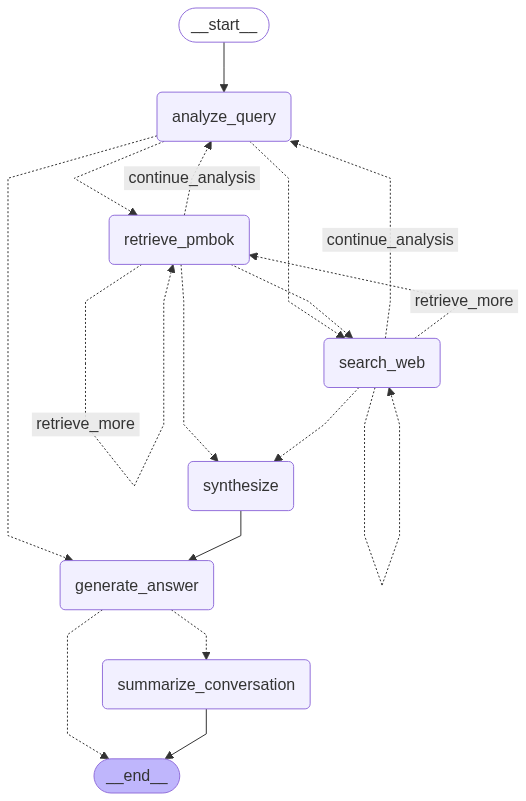

In [20]:
# Visualize the graph
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization not available:", e)
    print("Iterative Graph Structure:")
    print("analyze_query -> [needs_tools?] -> retrieve_pmbok -> [continue_analysis?] -> analyze_query (loop)")
    print("retrieve_pmbok -> [continue_analysis?] -> search_web -> [continue_analysis?] -> analyze_query (loop)")
    print("retrieve_pmbok/search_web -> [continue_analysis?] -> synthesize -> generate_answer")
    print("analyze_query -> [no tools needed] -> generate_answer")
    print("\nThe agent can now iterate through analysis and retrieval multiple times!")

In [21]:
# config = {"configurable": {"thread_id": "1"}}

In [22]:
# initial_state = State(
#         messages=[HumanMessage(content="How are you doing?")],
#     )
# result = app.invoke(initial_state, config)

In [23]:
# import pprint
# pprint.pprint(result["final_answer"])



In [24]:
# app.get_state(config)

In [25]:
def test_pm_assistant(query: str, config):
    """
    Test function to run the project management assistant with a given query.
    """
    print(f"Query: {query}")
    print("-" * 50)
    
    # Initialize with the query using proper LangChain message objects
    from langchain_core.messages import HumanMessage
    initial_state = State(
        messages=[HumanMessage(content=query)],
        plan=[],
        retrieved_docs=[],
        search_results=[],
        summary="",
        final_answer="",
        session_summary=""
    )
    
    # Run the graph
    result = app.invoke(initial_state, config)
    
    print("Final Answer:")
    print(result["final_answer"])
    print("\n" + "="*50 + "\n")
    
    # Show the analysis iterations
    print("Analysis Iterations:")
    for i, plan in enumerate(result.get("plan", []), 1):
        print(f"Iteration {i}: {plan.content[:200]}...")
    
    return result

# Example test queries (uncomment to test)
# test_pm_assistant("What are the key phases in project management according to PMBOK?")
# test_pm_assistant("How do I create an effective project charter?")
# test_pm_assistant("What are the latest trends in agile project management?")

In [26]:
# # Test the improved deterministic routing system
# print("Testing Deterministic Routing System")
# print("="*50)

# # Test with a simple PMBOK query to see the explicit decision-making
# test_config = {"configurable": {"thread_id": "test_deterministic"}}
# result = test_pm_assistant("What are the five process groups in PMBOK?", test_config)

## Deterministic Routing Improvements

The conditional edges have been revised to be more deterministic by:

### 1. Explicit Agent Decision-Making
Instead of keyword matching, the agent now explicitly decides:
- **`needs_tools()`**: Agent decides if tools are needed or if it can answer directly
- **`should_continue_analysis()`**: Agent decides next step based on context and information gathered
- **`determine_retrieval_type()`**: Agent decides between PMBOK retrieval or web search

### 2. Structured Decision Prompts
Each routing function uses clear prompts that:
- Provide context about current state
- List available options explicitly
- Ask for exact response format
- Consider multiple factors for decision-making

### 3. Benefits
- **More Intelligent**: Decisions based on understanding, not pattern matching
- **More Reliable**: Less prone to unexpected routing due to keyword variations
- **More Transparent**: Clear reasoning behind each routing decision
- **More Flexible**: Can adapt to complex scenarios that don't fit simple keyword patterns

### 4. Decision Factors
The agent now considers:
- Information already gathered
- Analysis iteration count (prevents loops)
- Query context and requirements
- Plan execution status
- Resource availability

In [27]:
# Complex Scenario Test: Multi-faceted Project Management Challenge
print("Testing Complex Multi-Step Scenario")
print("="*60)

complex_scenario = """
I'm leading a digital transformation project for a mid-sized manufacturing company with 500 employees. Here's my challenging situation:

CONTEXT:
- Project timeline: 18 months, budget: $2.5M
- We're implementing a new ERP system, updating legacy manufacturing systems, and training all staff
- The company has never done a project this large before
- We have a mix of tech-savvy and traditional employees
- Senior leadership is supportive but concerned about disrupting operations
- We're in a competitive market and can't afford significant downtime

CURRENT CHALLENGES:
1. The original vendor we selected just went out of business (3 months into the project)
2. Our IT department is overwhelmed and requesting to pause the project
3. Two key stakeholders are now pushing for completely different solutions
4. We've already spent 30% of our budget
5. Manufacturing teams are resistant to change and worried about job security
6. Our project charter needs major revisions due to scope changes
7. The CEO wants to accelerate the timeline due to competitive pressures

IMMEDIATE QUESTIONS:
- How do I restructure this project to get back on track?
- What's the best approach for vendor reselection under time pressure?
- How do I manage stakeholder conflicts while keeping the project moving?
- Should I break this into smaller phases or continue as one large project?
- How do I address team concerns while maintaining momentum?
- What risk mitigation strategies should I prioritize?
- How do I communicate these changes to all stakeholders effectively?

I need a comprehensive action plan that addresses both immediate crisis management and long-term project success. What would you recommend?
"""

# Test with complex scenario that should trigger multiple iterations
test_config = {"configurable": {"thread_id": "complex_scenario_test"}}
result = test_pm_assistant(complex_scenario, test_config)

Testing Complex Multi-Step Scenario
Query: 
I'm leading a digital transformation project for a mid-sized manufacturing company with 500 employees. Here's my challenging situation:

CONTEXT:
- Project timeline: 18 months, budget: $2.5M
- We're implementing a new ERP system, updating legacy manufacturing systems, and training all staff
- The company has never done a project this large before
- We have a mix of tech-savvy and traditional employees
- Senior leadership is supportive but concerned about disrupting operations
- We're in a competitive market and can't afford significant downtime

CURRENT CHALLENGES:
1. The original vendor we selected just went out of business (3 months into the project)
2. Our IT department is overwhelmed and requesting to pause the project
3. Two key stakeholders are now pushing for completely different solutions
4. We've already spent 30% of our budget
5. Manufacturing teams are resistant to change and worried about job security
6. Our project charter needs 

In [28]:
# # Complex Scenario Test - Multi-Stakeholder Remote Project Challenge
# print("🚀 COMPLEX SCENARIO TEST")
# print("="*60)

# scenario_query = """
# I'm leading a critical software development project for a healthcare client with the following challenging situation:

# **Project Context:**
# - 8-month timeline to deliver a patient management system
# - $2.5M budget with fixed-price contract
# - Remote team across 4 time zones (US West Coast, US East Coast, India, UK)
# - 15 developers, 3 QA engineers, 2 UX designers, 1 data architect
# - Client has never worked with agile methodologies (very traditional, waterfall-oriented)

# **Current Crisis Points:**
# 1. We're at month 3, and the client just added a new Chief Medical Officer who wants to completely revise the user requirements
# 2. The development team in India is 2 weeks behind due to unexpected regulatory compliance requirements
# 3. The UX team discovered major accessibility issues that weren't in original requirements
# 4. Client is pushing for a demo in 2 weeks for their board meeting, but we only have 40% of planned features completed
# 5. Budget is already 15% overrun due to the compliance work
# 6. Team morale is low due to constant requirement changes and pressure

# **Immediate Decisions Needed:**
# - How do I restructure the project plan and timeline?
# - What's the best way to manage the new CMO's requirements without derailing the project?
# - How should I handle the budget overrun conversation with the client?
# - What project management approach should I use to get back on track?
# - How do I improve team coordination across time zones?
# - What should I present at the board demo to maintain confidence?

# This feels overwhelming - I need a comprehensive strategy that addresses all these interconnected issues. What would you recommend as my action plan?
# """

# # Test with the complex scenario
# test_config = {"configurable": {"thread_id": "complex_scenario_test"}}
# result = test_pm_assistant(scenario_query, test_config)